In [299]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Set random seed
seed = 42

In [300]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')


In [301]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8763 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               6912 non-null   object 
 13  title                 8784 non-null   object 
 14  video                 8784 non-null   int64  
 15  vote_average         

# Scoring prediction

In [302]:
# Encode categorical variables
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

In [303]:
X = df.drop(columns=['vote_average', 'category'])
Y = df['category']
print(df)


      adult     budget                                          genres  \
0         0  200000000       Adventure,Action,Thriller,Science Fiction   
1         0  130000000                Science Fiction,Action,Adventure   
2         0  165000000                Action,Adventure,Science Fiction   
3         0  120000000                Action,Adventure,Science Fiction   
4         0   78000000   Fantasy,Action,Crime,Science Fiction,Thriller   
...     ...        ...                                             ...   
8779      0          0  Mystery,Animation,Comedy,Family,Action,Fantasy   
8780      0          0                                     Documentary   
8781      0          0                                    Comedy,Crime   
8782      0          0                                    Action,Crime   
8783      0          0                                    Drama,Comedy   

     original_language                                           overview  \
0                   en  For centur

In [304]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [305]:
#print(X.info())

In [306]:
#print(X.head())

In [ ]:
from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer

# Drop text columns with too many unique values
X = X.drop(columns=['genres', 'overview', 'production_companies', 'spoken_languages', 'tagline', 'title', 'cast', 'directors'])

#Discretize Numerical Features with High Unique Values using quantile binning
# Numerical features to discretize
numerical_features_to_discretize = ['budget', 'revenue','popularity', 'vote_count', 'runtime', 'release_year']

# Other numerical features (not being discretized)
other_numerical_features = ['release_month', 'release_day']

categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']


# Binning transformer for numerical features with high unique values
binning_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))  # 10 bins, quantile strategy
])

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_num', binning_transformer, numerical_features_to_discretize),
        ('num', numeric_transformer, other_numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Transparent Models

## Decision Tree

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. 


In [308]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) 
                            for i in range(len(elements)) if counts[i] > 0])
    return entropy_value

In [309]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

2.0
[0 1 2 3]
[2196 2196 2196 2196]


In [310]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name])
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    # Weighted entropy calculation
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data[data[split_attribute_name].astype(str) == values[i]][target_name])
        for i in range(len(values)) if counts[i] > 0
    ])
    
    return total_entropy - weighted_entropy

In [311]:
#igainex1 = info_gain(df, 'budget')
#print(igainex1)

#igainex2 = info_gain(df, 'popularity')
#print(igainex2)

#igainex3 = info_gain(df, 'spoken_languages')
#print(igainex3)

In [312]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) 
                                 for i in range(len(values)) if counts[i] > 0])
    return information_gain / split_information if split_information != 0 else 0

In [313]:
print(df.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'directors', 'release_year',
       'release_month', 'release_day', 'category'],
      dtype='object')


In [314]:
#igrex1 = info_gain_ratio(df, 'budget')
#print(igrex1)

#igrex2 = info_gain_ratio(df, 'popularity')
#print(igrex2)

#igrex3 = info_gain_ratio(df, 'spoken_languages')
#print(igrex3)


In [315]:
# Count unique values in each column using nunique()
n = df.nunique()

print("Number of unique values in each column:\n", n)

Number of unique values in each column:
 adult                      1
budget                   697
genres                  1839
original_language         38
overview                8759
popularity              7434
production_companies    7316
production_countries     787
revenue                 5150
runtime                  164
spoken_languages         858
status                     1
tagline                 6870
title                   8534
video                      2
vote_average              17
vote_count              2902
cast                    8776
directors               4194
release_year             103
release_month             12
release_day               31
category                   4
dtype: int64


In [316]:
igrex1 = info_gain_ratio(df, 'cast')
print(igrex1)

igrex2 = info_gain(df, 'cast')
print(igrex2)

igrex1 = info_gain_ratio(df, 'video')
print(igrex1)

igrex2 = info_gain(df, 'video')
print(igrex2)

0.15266723343832633
1.9997723132969034
0.034721962625682855
0.0002836078058925384


In [317]:
def c45_tree(data, original_data, features, target_name='category', parent_node_class=None, depth=0):
    print(f"Building tree at depth {depth}, dataset size: {len(data)}")
    
    if len(np.unique(data[target_name])) <= 1:
        print(f"Pure node reached with class: {np.unique(data[target_name])[0]}")
        return np.unique(data[target_name])[0]
    
    if len(data) == 0:
        print(f"Empty dataset at depth {depth}, returning parent class: {parent_node_class}")
        return parent_node_class
    
    if len(features) == 0:
        print(f"No features left at depth {depth}, returning majority class: {parent_node_class}")
        return parent_node_class
    
    current_majority_class = data[target_name].mode()[0]
    if parent_node_class is None:
        parent_node_class = current_majority_class
    
    gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
    print(f"Gain Ratios at depth {depth}: {dict(zip(features, gain_ratios))}")
    
    best_feature_index = np.argmax(gain_ratios)
    best_feature = features[best_feature_index]
    
    
    if gain_ratios[best_feature_index] == 0:
        print(f"No gain from any feature at depth {depth}, returning majority class: {current_majority_class}")
        return current_majority_class

    tree = {best_feature: {}}
    for value in np.unique(data[best_feature].astype(str)):
        print(f"Splitting on {best_feature} = {value} at depth {depth}")
        sub_data = data[data[best_feature].astype(str) == value]
        subtree = c45_tree(
            sub_data, original_data, 
            [f for f in features if f != best_feature], 
            target_name, current_majority_class, depth + 1
        )
        tree[best_feature][value] = subtree
    print(f"Subtree at depth {depth} for feature {best_feature}: {tree}")

    

    return tree


In [318]:
# Fit and transform X_train with the binning transformer
X_train_binned = binning_transformer.fit_transform(X_train[numerical_features_to_discretize])
X_test_binned = binning_transformer.transform(X_test[numerical_features_to_discretize])

# Convert the binned data back to DataFrame with original feature names
X_train_binned_df = pd.DataFrame(X_train_binned, columns=numerical_features_to_discretize, index=X_train.index)
X_test_binned_df = pd.DataFrame(X_test_binned, columns=numerical_features_to_discretize, index=X_test.index)

# Replace the original numerical features in X_train and X_test with the binned versions
X_train.update(X_train_binned_df)
X_test.update(X_test_binned_df)

# Print the results
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
X_test columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [319]:
featureList = df.columns[~df.columns.isin(['category', 'vote_average', 'genres', 'overview',
                                           'production_companies', 'spoken_languages', 'tagline',
                                           'title', 'cast', 'directors'])].tolist()
print(featureList)
print(Y_train)


['adult', 'budget', 'original_language', 'popularity', 'production_countries', 'revenue', 'runtime', 'status', 'video', 'vote_count', 'release_year', 'release_month', 'release_day']
6315    2
2484    1
167     0
5700    2
367     0
       ..
5734    2
5191    2
5390    2
860     0
7270    3
Name: category, Length: 7027, dtype: int32


In [320]:
unique_counts = X_train.nunique()
print(unique_counts)


adult                      1
budget                     7
genres                  1608
original_language         36
overview                7009
popularity                10
production_companies    5913
production_countries     681
revenue                    7
runtime                   10
spoken_languages         717
status                     1
tagline                 5534
title                   6842
video                      2
vote_count                10
cast                    7024
directors               3629
release_year              10
release_month             12
release_day               31
dtype: int64


In [321]:
print(pd.concat([X_train, Y_train], axis=1).columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day', 'category'],
      dtype='object')


In [322]:


c45tree = c45_tree(
    pd.concat([X_train, Y_train], axis=1),
    pd.concat([X_train, Y_train], axis=1),
    featureList
)


print(c45tree)

Building tree at depth 0, dataset size: 7027
Gain Ratios at depth 0: {'adult': 0, 'budget': 0.0544003069048478, 'original_language': 0.0686319210082145, 'popularity': 0.06022524350790091, 'production_countries': 0.07595161947029101, 'revenue': 0.075083916996401, 'runtime': 0.05949952881650796, 'status': 0, 'video': 0.041389484884905736, 'vote_count': 0.18566480750591483, 'release_year': 0.02993276918291375, 'release_month': 0.0036726589108952252, 'release_day': 0.0025742809862175048}
Splitting on vote_count = 0.0 at depth 0
Building tree at depth 1, dataset size: 692
Pure node reached with class: 0
Splitting on vote_count = 1.0 at depth 0
Building tree at depth 1, dataset size: 712
Gain Ratios at depth 1: {'adult': 0, 'budget': 0.03141473887966524, 'original_language': 0.08081669029024689, 'popularity': 0.011770677734075398, 'production_countries': 0.06109312432234121, 'revenue': 0.015752354154301988, 'runtime': 0.05352383228342706, 'status': 0, 'video': 0.028361624911041335, 'release_

In [323]:
def tree_predict(tree, sample, parent_node_class=None):
    # If the current tree node is a leaf, return the class
    if not isinstance(tree, dict):
        return tree

    # The current feature to split on
    feature = next(iter(tree))

    # Get the feature value from the sample
    feature_value = str(sample.get(feature, None))

    # Find the subtree that matches the feature value
    subtree = tree[feature].get(feature_value, None)

    # If no subtree exists, return the majority class of the parent node
    if subtree is None:
        return parent_node_class

    # Recursively predict using the subtree
    return tree_predict(subtree, sample, parent_node_class)


In [324]:
print(X_test.columns) 

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


In [325]:

parent_class = Y_train.mode()[0]
Y_pred = [tree_predict(c45tree, sample, parent_class) for _, sample in X_test.iterrows()]


print("Majority class (fallback):", parent_class)
print("Predictions:", Y_pred)


Majority class (fallback): 3
Predictions: [2, 0, 1, 3, 3, 2, 2, 3, 1, 1, 1, 3, 3, 0, 3, 3, 0, 0, 3, 0, 1, 0, 3, 1, 3, 3, 2, 0, 1, 3, 2, 0, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 2, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 1, 3, 2, 2, 3, 3, 3, 3, 0, 1, 1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 0, 1, 2, 2, 2, 0, 3, 0, 1, 2, 1, 2, 1, 3, 0, 3, 3, 3, 1, 3, 2, 0, 1, 1, 2, 2, 0, 3, 2, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 2, 0, 2, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 0, 3, 2, 0, 3, 2, 3, 3, 1, 2, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 2, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 0, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 0, 1, 0, 3, 3, 3, 0, 2, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 2, 3, 3, 3, 0, 3, 3, 

Accuracy:  0.47410358565737054
[0, 1, 2, 3]
category
2    457
0    454
1    427
3    419
Name: count, dtype: int64


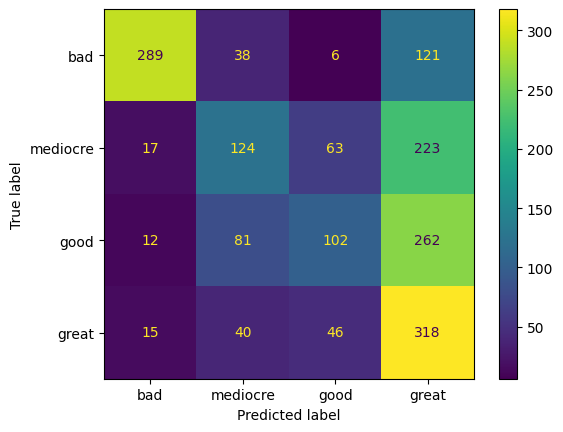

In [326]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: ", accuracy)


print(sorted(Y_test.unique()))
print(Y_test.value_counts())


cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()


In [327]:
def calculate_c45_tree_complexity(tree, depth=0):
    if not isinstance(tree, dict):
        return 1, 1, depth  

    num_nodes = 1  
    num_leaves = 0
    max_depth = depth

    # Recursively count nodes and leaves for each child subtree
    feature = next(iter(tree))
    for value, subtree in tree[feature].items():
        subtree_nodes, subtree_leaves, subtree_depth = calculate_c45_tree_complexity(subtree, depth + 1)
        num_nodes += subtree_nodes
        num_leaves += subtree_leaves
        max_depth = max(max_depth, subtree_depth)

    return num_nodes, num_leaves, max_depth


num_nodes, num_leaves, max_depth = calculate_c45_tree_complexity(c45tree)

print(f"Number of nodes: {num_nodes}")
print(f"Number of leaves: {num_leaves}")
print(f"Maximum depth of the tree: {max_depth}")


Number of nodes: 5879
Number of leaves: 4790
Maximum depth of the tree: 9


In [328]:
def print_c45_tree(tree, depth=0):
    if not isinstance(tree, dict):
        print("  " * depth + f"--> {tree}")
        return

    feature = next(iter(tree))
    for value, subtree in tree[feature].items():
        print("  " * depth + f"[{feature} == {value}]")
        print_c45_tree(subtree, depth + 1)


print("C4.5 Decision Tree Structure:")
print_c45_tree(c45tree)


C4.5 Decision Tree Structure:
[vote_count == 0.0]
  --> 0
[vote_count == 1.0]
  [original_language == cn]
    [budget == 0]
      --> 3
    [budget == 4]
      --> 0
  [original_language == da]
    --> 3
  [original_language == de]
    [release_day == 1]
      --> 3
    [release_day == 17]
      --> 0
    [release_day == 22]
      --> 0
    [release_day == 23]
      --> 3
    [release_day == 29]
      --> 0
  [original_language == en]
    [video == 0]
      [runtime == 0.0]
        [production_countries == Australia]
          --> 0
        [production_countries == Belgium,France]
          --> 0
        [production_countries == Belgium,United States of America]
          --> 0
        [production_countries == Canada]
          --> 0
        [production_countries == Canada,United Kingdom]
          --> 0
        [production_countries == Canada,United States of America]
          --> 0
        [production_countries == France]
          --> 0
        [production_countries == France,Spain